# Example: Optimal stopping of fractional Brownian motion

In this notebook we show how to use the code from https://github.com/lucapelizzari/Optimal_Stopping_with_signatures/tree/main to compute lower and upper bounds for the optimal stopping value of fractional Brownian motion, see Section 4.1 in https://arxiv.org/abs/2312.03444.

Recall from Section 4.1 in the paper, that we wish to solve the problem $$\sup_{\tau\in \mathcal{S}_0^{100}}\mathbb{E}(X^H_{\tau}),$$ where $X^H$ is a fractional Brownian motion with Hurst parameter $H\in (0,1)$, and we maximize over stopping times on $0=t_0<\dots<t_{100}=1$. In both the primal and dual formulation, we approximate the solution using $K$-step signature lifts of the paths $t \mapsto (t,X_t^H)$.

## Step 1: Install packages and functions

The iisignature package is used to compute the path-signature, and the gurobi package will be applied to solve efficiently solve high-dimensional linear programs. A license from the latter is required, and one can obtain a free-license on https://www.gurobi.com/academia/academic-program-and-licenses/.

In [1]:
!pip install iisignature
!pip install gurobipy

The file Optimal_Stopping_fBM_Signatures.py contains the functions to compute lower and upper-bounds

In [2]:
from Optimal_Stopping_fBM_Signatures import LongstaffSchwartz_signature_fBm, DualSAA_signature_fBm

## Step 2: Define parameters for the optimal stopping problem

In [3]:
K_primal = 5 #Signature trunctation primal
K_dual = 4 #Signature truncation dual
N = 100 #number of stopping dates
J = 100 #discretization-grid for computing the siganture (that is iterated integrals)
H = 0.3 #Hurst Parameter
T = 1 #Final time
M1_primal = 50000 #number of samples for the Longstaff-Schwartz procedure
M2_primal = 50000 #number of samples for independent resimulation to get lower-bounds
M1_dual = 5000 #number of samples for the SAA dual procedure
M2_dual = 50000 #number of samples for independent resimulation to get lower-bounds


## Step 3: Compute lower bounds

The function LongstaffSchwartz_signature_fBm returns (true) lower bounds, optimal stopping policies and the total run-time. Here is a quick summary of the procedure:
- First it applies the Longstaff-Schwartz algorithm with signatures described in Section 3.2 of the paper, using M1_primal samples of the fBm. This yields linear functionals of the truncated signature at each stopping date, approxmating the continuation values.
- Second, by independently resimulating M2_primal paths of the fBm, for each path the function uses the linear functionals to decide the optimal stopping time, which is the first exercise-dates where the payoff dominates the linear functional.
- Finally, by averaging over all paths at their optimal stopping time, the function returns a true lower-bound.

In [4]:
y_lowerbound,stopping_policies,run_time_primal = LongstaffSchwartz_signature_fBm(M1_primal,M2_primal,J,N,T,K_primal,H)

In [5]:
print('a lower bound is given by',y_lowerbound)

a lower bound is given by 0.3659230140275182


## Step 4: Compute upper bounds

The function DualSAA_signature_fBm returns (true) upper bounds, the martingale coefficients and the total run time. Here is a quick summary of the procedure:
- First it constructs the familiy of basis martingales described in Section 3.3, that is (discretized) stochastic integrals with signature integrands, for all M1_dual sample-paths.
- Then the linear program described in Remark 3.10 is solved using Gurobi, which returns optimal coefficients (and thus an optimal martingale).
- After independently resimulating M2_dual paths, the function computes the approximating martingale with the given coefficients with respect to the new samples, and get a true upper-bound for the price by averaging.

Attention: To run the following you need to have a license from Gurobi, here is where you can get it and how to install it https://www.gurobi.com/academia/academic-program-and-licenses/. Also notice that depending on the number of samples, it can take some time to run the code (e.g. for M1_dual = 5000 and K=4, 1-2 minutes).

In [6]:
y_upperbound,coefficients,run_time_dual = DualSAA_signature_fBm(M1_dual,M2_dual,J,N,T,K_dual,H)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-26
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
43.58624315261841  seconds needed to solve the linear program
true upper bound 0.39502281255934374 with STD 0.0883198762036211


Finally, we can print the interval of the lower and upper bounds.

In [7]:
print('The true values lies within in interval',[y_lowerbound,y_upperbound])

The true values lies within in interval [0.3659230140275182, 0.39502281255934374]


# A closer look into signature stopping policies and Doob martingales

Let us have a closer look at the signautre stopping policies, resp. the optimal martingale we computed in Step 3 and 4. We use the FBM_package to simulate paths of fractional Brownian motion, and then compute the time-augmented signature.

In [8]:
from FBM_package import FBM
F,dfBm,dW = FBM(N,5,H,method = 'cholesky').fbm() 

F = F.transpose() #5 samples of the fractional Brownian motion
dfBm = dfBm.transpose() #increments of the fBm
dW = dW.transpose() #increments of the corresponding Brownian motion

Let us plot some example paths of the fBm, that is the process we try to optimally stop.

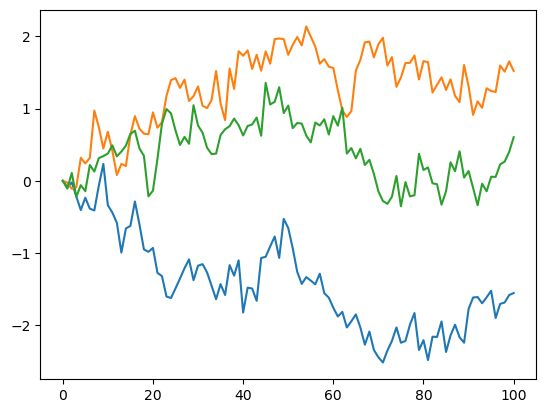

In [9]:
import matplotlib.pyplot as plt
plt.plot(F[0,:])
plt.plot(F[1,:])
plt.plot(F[2,:])

Next we compute the signature of level K_primal for all paths, using the iisignature package.

In [10]:
from helpfunctions import SignatureFull

In [11]:
import numpy as np
tt = np.linspace(0,T,N+1)
S_primal = SignatureFull(tt, dfBm.reshape(5,N,1), K_primal)
S_dual = SignatureFull(tt, dfBm.reshape(5,N,1), K_dual)

The following plot shows some different levels of the signature for one sample.

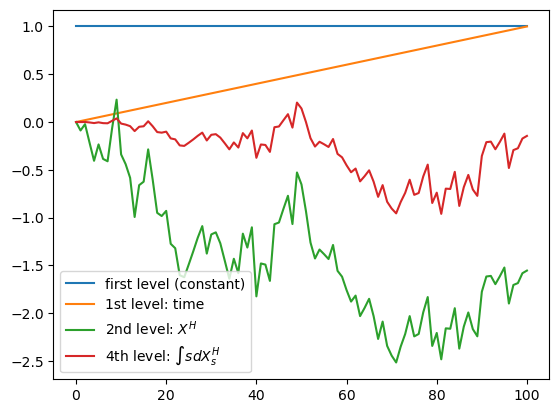

In [12]:
plt.plot(S_primal[0,:,0],label = 'first level (constant)')
plt.plot(S_primal[0,:,1],label = '1st level: time ')
plt.plot(S_primal[0,:,2],label = '2nd level: $X^H$')
plt.plot(S_primal[0,:,4],label = '4th level: $\int sdX^H_s $')
plt.legend()

## Primal signature stopping policies example

Recall that the optimal stopping time for a given sample of the fBM, say $X^{H,(i)}$ for some $i$, is given by $$\tau^{(i)}= \inf\{{t_k: \theta_k(\mathbb{X}_{t_k}^{\leq K,(i)}) \leq X^{(H),i}_{t_k}}\},$$ where $\mathbb{X}^{\leq K,(i)}$ is the signature of $(t,X^{H,(i)}_t)$, and $\theta_k$ are the linear functionals approximating the continuation value, computed in Step 3, that is stopping_policies. We can compute optimal stopping times for all the samples of the fBm

In [13]:
stopping_policies_function = [0]*5 #initalize by final time, if we can note stopp optimally we have to stop at the last time.
subindex = [int((j+1)*J/N) for j in range(N)] #in case J>N, these are the indices of the exercise date in the finer grid.
S_primal_exercise = S_primal[:,subindex,:] #signature at exercise dates only
F_exercise = F[:,subindex] #fBm at exercise dates only
for k in range(5):
    #for each sample, we stop the first time the payoff (here just the fBm value), dominates the linear functional
    j = 0
    while stopping_policies[j].predict(S_primal_exercise[k:k+1,j,:])> F_exercise[k,j]:
        j = j+1
        if j == N-1:
                break
    stopping_policies_function[k] = [0 if x<tt[subindex][j] else 1 for x in tt] 
    
    

For any sample we can now look when the signature stopping policies stops the process

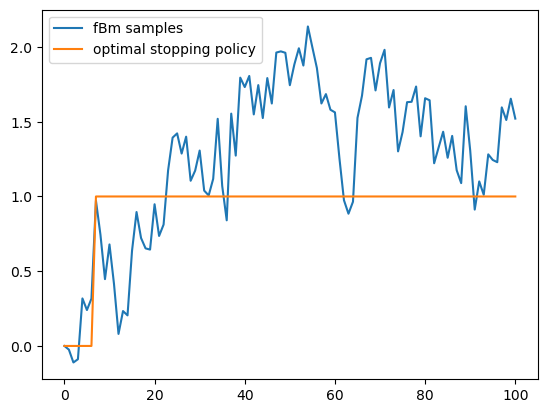

In [14]:
plt.plot(F[1,:],label ='fBm samples')
plt.plot(stopping_policies_function[1],label='optimal stopping policy')
plt.legend()

## Dual optimal martingale example

Recall that the optimal martingale is given by $M^{\theta}_{t_k} = \sum_{j}\theta(\mathbb{X}^{\leq K}_{t_j})(W_{t_{j+1}}-W_{t_j})$, where $\theta$ is the linear functional of the signature we computed in Step 3, i.e. the coefficients $\alpha_i$ such that $\theta(\mathbb{X}_t^{\leq K}) = \sum_j \alpha_j \langle\mathbb{X}^{\leq K}_{t_j},w_j \rangle$. It is an approximation of the dual optimal stopping formulation $$y_0 = \inf_{M}\mathbb{E}(\max_{1\leq k \leq N}(X^H_{t_k}-M_{t_k}))$$ We first computed the familiy of martingales $M=(M^j)$ with $M^j=\int \langle\mathbb{X}^{\leq K}_{t_j},w_j \rangle dW$ using an Euler-Scheme, then using linearity we have $M^{\theta} = \alpha^{\top}M$.

In [15]:
D = len(S_dual[0,0,:]) #number of basis martingales
Martingale_familiy = np.zeros((5,N+1,D))
#recall that dW are the Brownian increments
for d in range(D):
    Martingale_familiy[:,1:N+1,d] = np.cumsum(S_dual[:,0:N,d]*dW,axis=1)

In [16]:
Doob_martingale = np.dot(Martingale_familiy,coefficients)

In the following plot we compare the optimal martingale with the corresponding Brownian motion

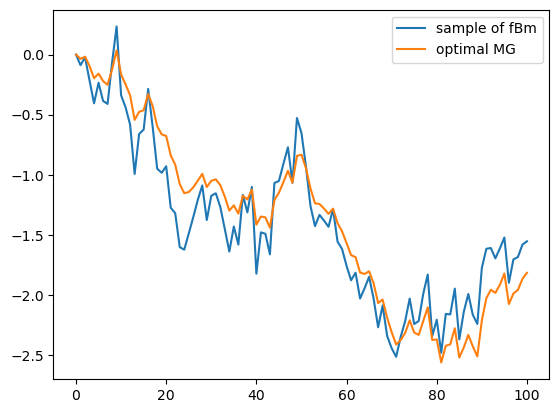

In [17]:
plt.plot(F[0,:],label ='sample of fBm')
plt.plot(Doob_martingale[0,:],label ='optimal MG')
plt.legend()